In [1]:
import pandas as pd
import numpy as np
df = pd.read_csv('../data.txt', sep='\s+')
df.atom_list = df.atom_list.apply(lambda x: list(map(int, x.split(','))))
atom_dict = {
    12: 'Mg',
    13: 'Al',
    20: 'Ca',
    22: 'Ti',
    23: 'V',
    24: 'Cr',
    25: 'Mn',
    26: 'Fe',
    27: 'Co',
    28: 'Ni',
    29: 'Cu',
    30: 'Zn',
    38: 'Sr',
    56: 'Ba',
}
for an, name in atom_dict.items():
    df[name] = df.atom_list.apply(lambda x: x.count(an) / len(x))
df_train = df[df.remark=='KS']
df_test = df[~(df.remark=='KS')]
X_train = df_train[atom_dict.values()]
y_train = df_train.Stabilized
X_test = df_test[atom_dict.values()]
y_test = df_test.Stabilized
X = df[atom_dict.values()]
y = df.Stabilized

# Random Forest

Using KS samples as training set.

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
clf = RandomForestClassifier(n_estimators=100).fit(X_train, y_train)
print(accuracy_score(y_test, clf.predict(X_test)))
print(roc_auc_score(y_test, clf.predict(X_test)))

0.8917525773195877
0.811525974025974


5-fold cross validation

In [3]:
from sklearn.model_selection import cross_val_score
result = cross_val_score(clf, X, y, cv=5)
for i in range(10):
    result = np.r_[result, cross_val_score(clf, X, y, cv=5)]
print(np.mean(result), np.std(result))

0.8449788797061526 0.06483165243220758


SHAP analysis

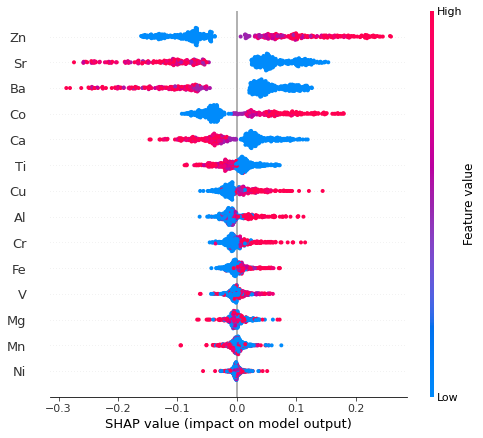

In [4]:
import shap
shap.initjs()
def shap_ana(clf, X, y):
    explainer = shap.TreeExplainer(clf)
    shap_values = explainer.shap_values(X)
    shap.summary_plot(shap_values[1], X)
    return explainer, shap_values
explainer, shap_values = shap_ana(clf, X, y)

(array([24.39734906,  7.100721  , 10.0138373 ,  3.64139538,  2.18483723,
         4.733814  ,  2.91311631,  3.27725584,  1.82069769,  1.63862792,
         1.09241861,  0.91034885,  0.72827908,  0.91034885,  0.72827908,
         1.63862792,  0.18206977,  0.54620931,  0.72827908,  0.18206977,
         0.36413954,  0.18206977,  0.        ,  0.        ,  0.36413954,
         0.36413954,  0.18206977,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.18206977,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.18206977,
         0.        ,  0.18206977,  0.18206977,  0.        ,  0.36413954,
         0.        ,  0.        ,  0.18206977,  0.18206977,  0.18206977]),
 array([-0.2002623, -0.1864623, -0.1726623, -0.1588623, -0.1450623,
        -0.1312623, -0.1174623, -0.1036623, -0.0898623, -0.0760623,
        -0.0622623, -0.0484623, -0.0346623, -0.0208623, -0.0070623,
         0.0067377,  0.0205377,  0.0343377,  0.0481377,  0.06193

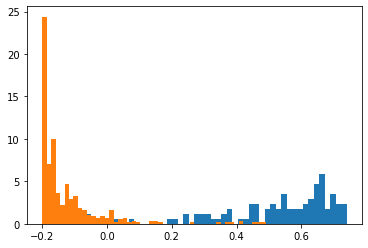

In [5]:
import matplotlib.pyplot as plt
plt.hist(shap_values[1][y == 1].sum(axis=1), bins=50, density=True)
plt.hist(shap_values[1][y == 0].sum(axis=1), bins=50, density=True)

# XGboost

Using KS samples as training set.

In [6]:
from xgboost import XGBClassifier
clf = XGBClassifier(n_estimators=100).fit(X_train, y_train)
print(accuracy_score(y_test, clf.predict(X_test)))
print(roc_auc_score(y_test, clf.predict(X_test)))

[17:30:45] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.9123711340206185
0.8707792207792209


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


In [7]:
from xgboost import XGBRFClassifier
clf = XGBRFClassifier(n_estimators=100).fit(X_train, y_train)
print(accuracy_score(y_test, clf.predict(X_test)))
print(roc_auc_score(y_test, clf.predict(X_test)))

[17:30:45] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.9175257731958762
0.874025974025974


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


5-fold cross validation

In [8]:
result = cross_val_score(clf, X, y, cv=5)
for i in range(10):
    result = np.r_[result, cross_val_score(clf, X, y, cv=5)]

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[17:30:45] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:30:45] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:30:45] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:30:45] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[17:30:45] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:30:45] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:30:45] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:30:46] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[17:30:46] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:30:46] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:30:46] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:30:46] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[17:30:46] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:30:46] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:30:46] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:30:46] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[17:30:46] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:30:46] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:30:46] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:30:46] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[17:30:47] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:30:47] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:30:47] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:30:47] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


In [9]:
print(np.mean(result), np.std(result))

0.8896767676767678 0.03785156732372338


SHAP analysis

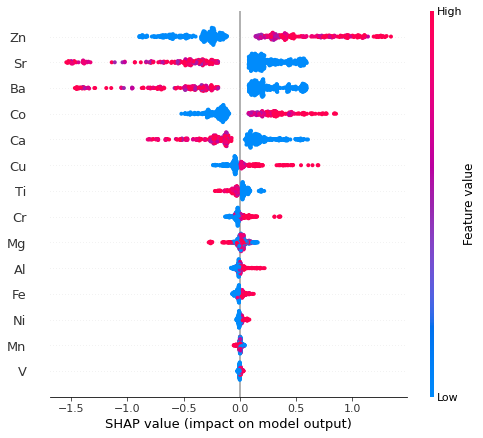

In [10]:
def shap_ana(clf, X, y):
    explainer = shap.TreeExplainer(clf)
    shap_values = explainer.shap_values(X)
    shap.summary_plot(shap_values, X)
    return explainer, shap_values
explainer, shap_values = shap_ana(clf, X, y)

(array([6.43940122, 1.93874604, 0.96937223, 0.76164961, 0.79627037,
        0.41544524, 0.17310225, 0.27696349, 0.13848178, 0.17310224,
        0.06924089, 0.17310222, 0.03462045, 0.10386133, 0.17310222,
        0.13848175, 0.17310225, 0.10386131, 0.        , 0.        ,
        0.03462044, 0.        , 0.        , 0.03462044, 0.        ,
        0.03462047, 0.        , 0.03462041, 0.03462047, 0.        ,
        0.06924093, 0.        , 0.06924082, 0.06924093, 0.1038614 ,
        0.06924082, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.06924082, 0.        ,
        0.        , 0.        , 0.        , 0.03462052, 0.06924082]),
 array([-0.80849844, -0.7359239 , -0.6633494 , -0.59077483, -0.5182003 ,
        -0.44562575, -0.3730512 , -0.30047667, -0.22790211, -0.15532757,
        -0.08275304, -0.0101785 ,  0.06239604,  0.13497058,  0.20754512,
         0.28011966,  0.3526942 ,  0.42526874,  0.4978433 ,  0.5704178 ,
         0.6429924 ,  0.71

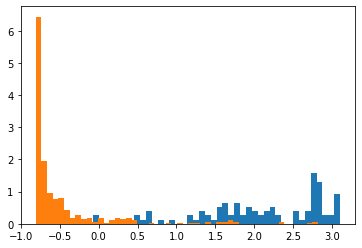

In [11]:
plt.hist(shap_values[y == 1].sum(axis=1), bins=50, density=True)
plt.hist(shap_values[y == 0].sum(axis=1), bins=50, density=True)

In [12]:
# visualize the training set predictions
shap.force_plot(explainer.expected_value, shap_values, X)

In [13]:
shap.force_plot(explainer.expected_value, shap_values, X)

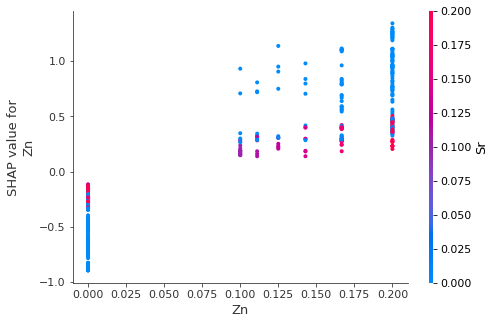

In [14]:
shap.dependence_plot("Zn", shap_values, X, interaction_index='Sr')

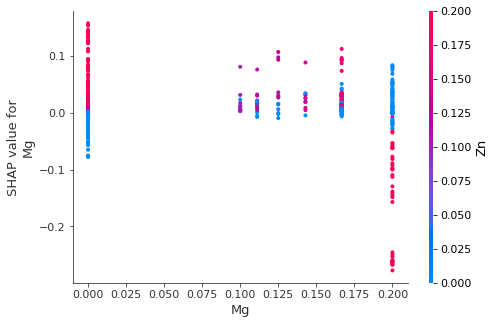

In [15]:
shap.dependence_plot("Mg", shap_values, X)

In [16]:
shap_interaction_values = shap.TreeExplainer(clf).shap_interaction_values(X)

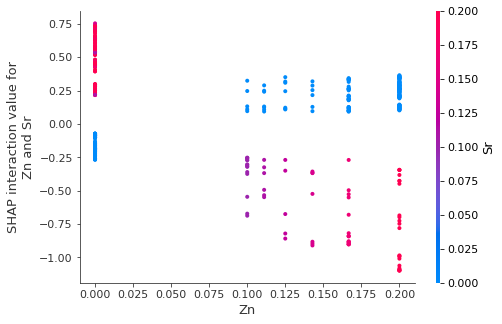

In [17]:
shap.dependence_plot(("Zn", "Sr"), shap_interaction_values, X)